In [1]:
# set cell display width
from IPython.display import display, HTML
display(HTML('<style>.container { width: 930px !important; }</style>'))

In [2]:
# import ML tools
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from collections import defaultdict

In [3]:
# import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
# set grid size and style
figsize(12, 4)
sns.set_style('whitegrid')

Use "mp.colors(<index>)" as color attribute for Seaborn plots.
This is your color palette...


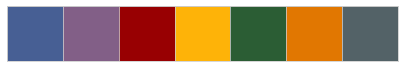

In [4]:
# import custom palette
import my_palette as mp

I will begin with the unaggregated actor dataset.

In [5]:
# read in actor dataset
actor_df = pd.read_json('data/capstone2_ref.json')

In [6]:
# observe actor by movie DataFrame before aggregation
actor_df.head()

,person_id,name,movie_id,title,revenue,budget,profit,age,gender,order,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
0,2,Mark Hamill,16121,The Big Red One,2.273880e+07,1.419948e+07,8.539315e+06,28.674100,0,1,...,0,0,0,0,0,0,0,0,1,0
1,2,Mark Hamill,11,Star Wars,3.319102e+09,4.708566e+07,3.272016e+09,25.665140,0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,Mark Hamill,14919,Batman: Mask of the Phantasm,9.944670e+06,1.062202e+07,-6.773465e+05,42.251381,0,1,...,0,0,0,0,1,0,0,1,0,0
3,2,Mark Hamill,1892,Return of the Jedi,1.490146e+09,8.417359e+07,1.405972e+09,31.663895,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2,Mark Hamill,16220,Wizards,3.930685e+07,5.240914e+06,3.406594e+07,25.377660,0,4,...,1,0,0,0,0,0,1,0,0,0


Each observation is of an actor and one of their movies.

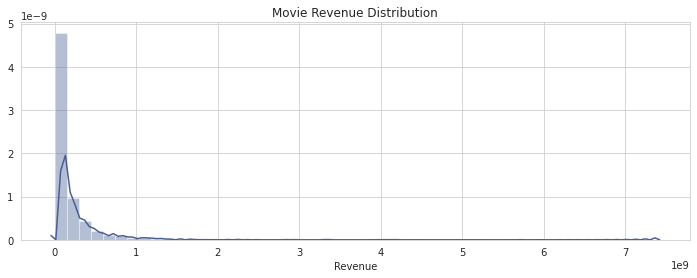

In [7]:
# plot movie revenue distribution

sns.distplot(actor_df['revenue'], color=mp.colors(0))

plt.xlabel('Revenue')

plt.title('Movie Revenue Distribution');

The distribution is quite broad.<br>
There are many outliers in the billions of dollars range.

In [8]:
# observe percentiles of unmodified movie revenues, before aggregation
actor_df['revenue'].describe()

count    4.131100e+04
mean     1.598474e+08
std      2.977362e+08
min      1.238841e+00
25%      1.705831e+07
50%      6.373003e+07
75%      1.802751e+08
max      7.377968e+09
Name: revenue, dtype: float64

The maximum movie revenue is over 7 billion dollars.<br>
Half of the movies have revenue over 60 million dollars.<br>
The average movie revenue is almost 160 million dollars.

I'll show some of the top earning movies in the dataset.

In [9]:
# get titles and revenues for movies with the top 0.5% of average revenues
actor_df[actor_df['revenue'] >= actor_df['revenue'].quantile(
    0.995)][['title', 'revenue']].drop_duplicates().sort_values(
    'revenue', ascending=False)

,title,revenue
8136,Gone with the Wind,7.377968e+09
11246,Alice in Wonderland,5.700455e+09
17006,Bambi,4.183765e+09
10746,Snow White and the Seven Dwarfs,3.361411e+09
4706,Avatar,3.332341e+09
1,Star Wars,3.319102e+09
987,Titanic,2.948799e+09
25989,Cinderella,2.895187e+09
536,Avengers: Endgame,2.825905e+09
5808,The Exorcist,2.465535e+09


This dataset spans over 100 years and is adjusted for inflation.

 > **UNMODIFIED REVENUES**

In [10]:
def aggregate_data(data, feature='person_id'):
    """Return aggregated DataFrame grouped by chosen feature"""
    # aggregate while making counts of genres and taking the average of all other values
    agg_actor_df = data.groupby(feature).agg(
        {'revenue': np.mean, 'budget': np.mean, 'age': np.mean, 'gender': 'first', 
         'order':np.mean, 'popularity':np.mean, 'release_date': np.mean, 
         'runtime': np.mean, 'usa': 'first', 'vote_average': np.mean, 
         'vote_count': np.mean, 'action': np.sum, 'adventure': np.sum, 
         'animation': np.sum, 'comedy': np.sum, 'crime': np.sum, 'drama': np.sum, 
         'family': np.sum, 'fantasy': np.sum, 'history': np.sum, 'horror': np.sum, 
         'music': np.sum, 'mystery': np.sum, 'romance': np.sum, 'science_fiction': np.sum, 
         'thriller': np.sum, 'war': np.sum, 'western': np.sum})
    
    return agg_actor_df

In [11]:
# aggregate over each actor and get DataFrame with unmodified revenues
df = aggregate_data(actor_df)
df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,1.032727e+09,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,4.376895e+08,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,7.803955e+08,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,1.147836e+09,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,1.471965e+09,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


The new dataset has been aggregated over each actor, taking the average of their movie revenues.<br>
This revenue will be the target of the predictions.

In [12]:
# separate data into features and target
X = df.drop('revenue', axis=1)
y = df['revenue']

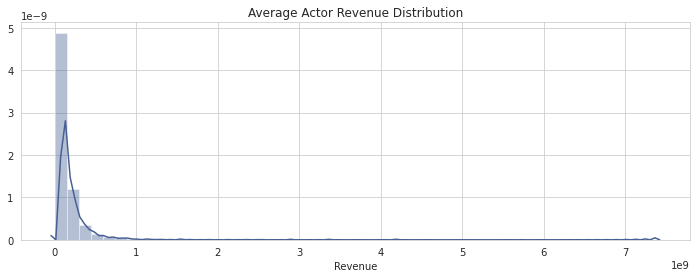

In [13]:
# plot average actor revenue distribution

sns.distplot(y, color=mp.colors(0))

plt.xlabel('Revenue')

plt.title('Average Actor Revenue Distribution');

The distribution is similar to the movie revenue distribution.

In [14]:
# observe percentiles of unmodified average actor revenues
df['revenue'].describe()

count    1.169300e+04
mean     1.386641e+08
std      2.847504e+08
min      1.238841e+00
25%      2.466701e+07
50%      7.589722e+07
75%      1.614848e+08
max      7.377968e+09
Name: revenue, dtype: float64

The maximum average actor revenue is over 7 billion dollars.<br>
Half of the actors have average revenues over 75 million dollars.<br>
The mean of the average actor revenue is almost 140 million dollars.

I'll show some of the top actors by average revenue

In [15]:
# get ids for actors with the top 0.1% of average revenues, sorted by revenue
top_actor_ids = df[df['revenue'] >= df['revenue'].quantile(0.999)].index
# get their names
top_actor_names = actor_df[actor_df['person_id'].isin(top_actor_ids)]['name'].unique()
# get their average revenues
top_actor_revenues = df[df.index.isin(top_actor_ids)]['revenue']
# create DataFrame with names and revenues
pd.DataFrame(list(zip(
    top_actor_names, 
    top_actor_revenues)), columns=['name', 'average_revenue']).sort_values(
    'average_revenue', ascending=False)

,name,average_revenue
0,Barbara O'Neil,7.377968e+09
1,Leslie Howard,7.377968e+09
2,Evelyn Keyes,7.377968e+09
3,Ann Rutherford,7.377968e+09
4,Hattie McDaniel,7.377968e+09
12,Jerry Colonna,5.700455e+09
5,Cammie King,4.183765e+09
6,Donnie Dunagan,4.183765e+09
7,Hardie Albright,4.183765e+09
8,Sam Edwards,4.183765e+09


These are not the actors usually listed among the top earners.<br>
The first 5 are from Gone With The Wind.<br>
The rest are from 2 Disney movies.<br>
Average actor revenues can be deceptively high, when there is only one film in consideration.

In [16]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27)

First, I will be observing the effects on model errors by modifying the actor revenues.<br>
Then, I will modify the movie revenues, before aggregation, for comparison.

I will be performing numeric transformations, such as taking the log and scaling.<br>
I will build a cross validation function from scratch.<br>
This is necessary to retain the predictions, while being able to transform them back to dollar amounts for interpretation.

In [17]:
def scratch_cv(features, target, log, scaled, scaled_df):
    """Return average mean absolute error from each 10 fold cross validation result"""
    # create empty list to hold MAE from each fold
    mae_lst = []    
    # instantiate KFold object
    folds = KFold(n_splits=10, random_state=27, shuffle=True)
    # split data into 10 folds
    for train_index, test_index in folds.split(features, target):
        train_features = features.iloc[train_index]
        train_target = target.iloc[train_index]
        test_features = features.iloc[test_index]
        test_target = target.iloc[test_index]
        # instantiate and fit model
        model = xgb.XGBRegressor(objective='reg:squarederror', random_state=27, 
                                 n_jobs=-1).fit(train_features, train_target)
        # get predictions
        y_pred = model.predict(test_features)
        # ensure returned errors are interpretable
        if log:
            # convert data from log dollars to dollars
            test_target = np.exp(test_target)
            y_pred = np.exp(y_pred)
        if scaled:
            # get column that was scaled
            y = scaled_df['revenue']
            # convert data from scaled dollars to dollars
            test_target = np.multiply(test_target, np.std(y)) + np.mean(y)
            y_pred = np.multiply(y_pred, np.std(y)) + np.mean(y)
        # calculate MAE for each fold and save results to list
        errors = np.absolute(y_pred - test_target)
        mae = np.mean(errors)
        mae_lst.append(mae)
        
    return mae_lst

In [18]:
def make_money(number):
    """Return dollar formatted string"""
    dollar = '${:,.2f}'.format(number)
    
    return dollar

In [19]:
# create default dict to store results of every form tried for representing revenue
revenue_dict = defaultdict(list)

def get_cv_mae(
    name, features, target, log=False, scaled=False, scaled_df=pd.DataFrame()):
    """Print average mean absolute error and error range from 10 fold cross validation"""
    # get average result from each CV fold
    mae_lst = scratch_cv(features, target, log, scaled, scaled_df)
    # get overall average MAE of the 10 folds
    average_mae = np.mean(mae_lst)
    # get MAE range over all 10 folds
    mae_range = (np.min(mae_lst), np.max(mae_lst))
    # store results for final comparison
    revenue_dict[name].append('{}'.format(make_money(average_mae)))
        
    print(name, '\nAverage MAE: {}       CV Range: ({}, {})'.format(
        make_money(average_mae), make_money(mae_range[0]), make_money(mae_range[1])))

In [20]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Original Revenues', X_train, y_train)

Original Revenues 
Average MAE: $56,799,637.33       CV Range: ($53,295,022.62, $58,574,028.26)


This is the base error that I will minimize through modifying the target.

 > **SCALED ACTOR REVENUE**

Now, I will perform scaling on the revenue values that were aggregated over each actor.

In [21]:
def scale_revenue(data):
    """Returns DataFrame with scaled revenue"""
    # get statistics of dataset used for scaling
    mean = np.mean(data['revenue'])
    std = np.std(data['revenue'])
    # create copy of dataset to return
    copy_df = data.copy()
    # apply scaling to dataset copy
    copy_df['revenue'] =  (copy_df['revenue'] - mean) / std
    
    return copy_df

In [22]:
# aggregate over each actor and get DataFrame with scaled actor revenue
scaled_df = scale_revenue(aggregate_data(actor_df))
scaled_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,3.139947,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,1.050176,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,2.253759,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,3.544210,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,4.682549,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [23]:
# separate training data into features and target
scaled_X = scaled_df.drop('revenue', axis=1)
scaled_y = scaled_df['revenue']

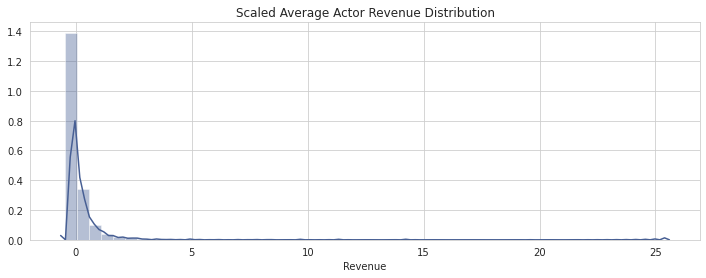

In [24]:
# plot target distribution

sns.distplot(scaled_y, color=mp.colors(0))

plt.xlabel('Revenue')

plt.title('Scaled Average Actor Revenue Distribution');

While the scale has been reduced, the outliers remain.<br>
The shape of the distribution is the same.

In [25]:
# split dataset
scaled_X_train, scaled_X_test, scaled_y_train, scaled_y_test = train_test_split(
    scaled_X, scaled_y, test_size=0.2, random_state=27)

In [26]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Scaled Revenues', scaled_X_train, scaled_y_train, scaled=True, scaled_df=df)

Scaled Revenues 
Average MAE: $56,914,594.28       CV Range: ($53,065,142.69, $59,283,239.38)


The improvement is marginal, after scaling the average actor revenue.

 > **LOG ACTOR REVENUE**

Now, I will observed the results of taking the natural log of the aggregated revenues.

In [27]:
def get_log_revenue(data):
    """Returns DataFrame with log of revenue"""
    # create copy of dataset to return
    copy_df = data.copy()
    # take log of dataset copy
    copy_df['revenue'] = np.log(copy_df['revenue'])
    
    return copy_df

In [28]:
# aggregate over each actor and get DataFrame with log actor revenue
log_df = get_log_revenue(aggregate_data(actor_df))
log_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,20.755469,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,19.897020,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,20.475311,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,20.861144,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,21.109864,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [29]:
# separate training data into features and target
log_X = log_df.drop('revenue', axis=1)
log_y = log_df['revenue']

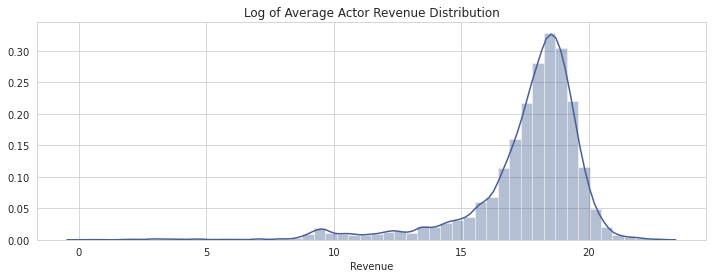

In [30]:
# plot target distribution

sns.distplot(log_y, color=mp.colors(0))

plt.xlabel('Revenue')

plt.title('Log of Average Actor Revenue Distribution');

The skew of the distribution has been reflected to the lower values.<br>
The distribution does not appear normal.

In [31]:
# split dataset
log_X_train, log_X_test, log_y_train, log_y_test = train_test_split(
    log_X, log_y, test_size=0.2, random_state=27)

In [32]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Log Revenues', log_X_train, log_y_train, log=True)

Log Revenues 
Average MAE: $59,562,756.22       CV Range: ($53,284,314.02, $69,808,156.21)


The errors are larger than those of the base model.<br>
Taking the log of the average actor revenue is counterproductive.

 > **NO OUTLIERS ACTOR REVENUE**

I will remove the outlier revenues after aggregating the datset by actor.<br>
An outlier is defined as lying greater than three standard deviations from the mean of the revenue distribution.

In [33]:
def remove_outliers(data, before_agg=False):
    """Return DataFrame after outliers have been identified and removed"""
    # create copy of dataset to identify outlier revenues
    copy_df = data.copy()
    # aggregate over movies, if data has not been aggregated over actors
    if before_agg:
        copy_df = aggregate_data(copy_df, feature='movie_id')
    # determine outlier cut off values
    mean = np.mean(copy_df['revenue'])
    std = np.std(copy_df['revenue'])
    cut_off = std * 3
    # define lower and upper bounds for outliers
    lower, upper = mean - cut_off, mean + cut_off
    # remove outlier revenues from dataset
    new_df = data[(data['revenue'] < upper) & (data['revenue'] > lower)]
    
    return new_df

In [34]:
# aggregate over each actor and get DataFrame with no outliers actor revenue
no_df = remove_outliers(aggregate_data(actor_df))
no_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
3,4.376895e+08,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,7.803955e+08,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
10,8.530622e+08,1.892706e+08,44.571757,0,4.500000,37.201500,2005.000000,94.000000,1,7.850000,...,0,0,0,0,0,0,0,0,0,0
12,7.067063e+08,9.858666e+07,10.421843,0,4.000000,22.071500,2004.500000,93.500000,1,6.950000,...,0,0,0,0,0,0,0,0,0,0
13,4.196991e+08,6.813673e+07,55.390099,0,3.000000,17.325636,2002.363636,108.181818,1,7.018182,...,1,0,1,0,0,2,1,3,0,0


In [35]:
# separate training data into features and target
no_X = no_df.drop('revenue', axis=1)
no_y = no_df['revenue']

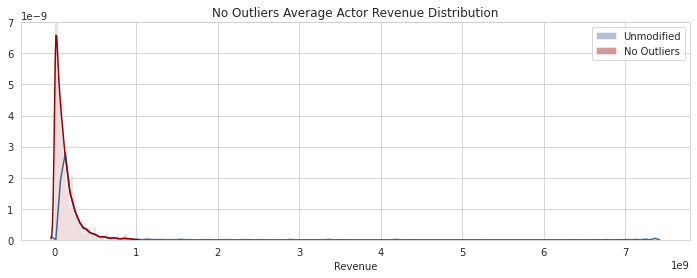

In [36]:
# plot target distributions

plt.ylim(top=7e-9)

sns.distplot(y, color=mp.colors(0), label='Unmodified', bins=500)
sns.distplot(no_y, color=mp.colors(2), label='No Outliers', bins=500)

plt.xlabel('Revenue')

plt.legend()
plt.title('No Outliers Average Actor Revenue Distribution');

The distribution is, now, shifted to lower values.

In [37]:
# split dataset
no_X_train, no_X_test, no_y_train, no_y_test = train_test_split(
    no_X, no_y, test_size=0.2, random_state=27)

In [38]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('No Outliers Revenues', no_X_train, no_y_train)

No Outliers Revenues 
Average MAE: $48,136,510.36       CV Range: ($43,905,831.29, $51,049,659.37)


The average error has been reduced by about 15%, after removing the outliers from the average actor revenue.

 > **NO OUTLIERS SCALED ACTOR REVENUE**

Now, I will combine two of the previous data manipulations, in succession.<br>
First, I will scale the aggregated data, then remove the scaled outliers.

In [39]:
# aggregate over each actor and get DataFrame with no outliers of scaled actor revenue
no_scaled_df = remove_outliers(scale_revenue(aggregate_data(actor_df)))
no_scaled_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
3,1.050176,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,2.253759,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
10,2.508964,1.892706e+08,44.571757,0,4.500000,37.201500,2005.000000,94.000000,1,7.850000,...,0,0,0,0,0,0,0,0,0,0
12,1.994963,9.858666e+07,10.421843,0,4.000000,22.071500,2004.500000,93.500000,1,6.950000,...,0,0,0,0,0,0,0,0,0,0
13,0.986994,6.813673e+07,55.390099,0,3.000000,17.325636,2002.363636,108.181818,1,7.018182,...,1,0,1,0,0,2,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,-0.486858,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,-0.485719,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,-0.485719,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [40]:
# separate training data into features and target
no_scaled_X = no_scaled_df.drop('revenue', axis=1)
no_scaled_y = no_scaled_df['revenue']

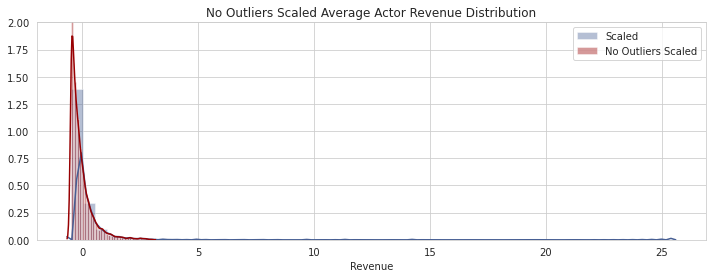

In [41]:
# plot target distributions
plt.ylim(top=2)

sns.distplot(scaled_y, color=mp.colors(0), label='Scaled')
sns.distplot(no_scaled_y, color=mp.colors(2), label='No Outliers Scaled')

plt.xlabel('Revenue')

plt.legend()
plt.title('No Outliers Scaled Average Actor Revenue Distribution');

The scale of the data is reduced by a factor of 10, and there is no outlier mode in the high values.

In [42]:
# split dataset
no_scaled_X_train, no_scaled_X_test, \
no_scaled_y_train, no_scaled_y_test = train_test_split(
    no_scaled_X, no_scaled_y, test_size=0.2, random_state=27)

In [43]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('No Outliers Scaled Revenues', no_scaled_X_train, no_scaled_y_train, 
           scaled=True, scaled_df=df)

No Outliers Scaled Revenues 
Average MAE: $48,271,338.54       CV Range: ($43,380,962.38, $51,034,797.72)


The results are slightly worse than simply using the unscaled data to identify outliers.

 > **LOG NO OUTLIERS ACTOR REVENUE**

The last modification of the aggregated data I will perform is taking the log of the revenue, after removing outliers.

In [44]:
# aggregate over each actor and get DataFrame with log of no outliers actor revenue
log_no_df = get_log_revenue(remove_outliers(aggregate_data(actor_df)))
log_no_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
3,19.897020,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,20.475311,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
10,20.564343,1.892706e+08,44.571757,0,4.500000,37.201500,2005.000000,94.000000,1,7.850000,...,0,0,0,0,0,0,0,0,0,0
12,20.376126,9.858666e+07,10.421843,0,4.000000,22.071500,2004.500000,93.500000,1,6.950000,...,0,0,0,0,0,0,0,0,0,0
13,19.855049,6.813673e+07,55.390099,0,3.000000,17.325636,2002.363636,108.181818,1,7.018182,...,1,0,1,0,0,2,1,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,10.515550,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,12.797395,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,12.797395,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [45]:
# separate training data into features and target
log_no_X = log_no_df.drop('revenue', axis=1)
log_no_y = log_no_df['revenue']

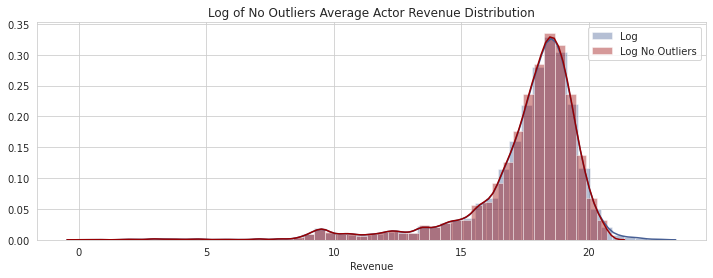

In [46]:
# plot target distributions

sns.distplot(log_y, color=mp.colors(0), label='Log')
sns.distplot(log_no_y, color=mp.colors(2), label='Log No Outliers')

plt.xlabel('Revenue')

plt.legend()
plt.title('Log of No Outliers Average Actor Revenue Distribution');

The distributions are very similar.<br>
The large values show the sharp drop off that results from eliminating the outliers.

In [47]:
# split dataset
log_no_X_train, log_no_X_test, \
log_no_y_train, log_no_y_test = train_test_split(
    log_no_X, log_no_y, test_size=0.2, random_state=27)

In [48]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Log No Outliers Revenues', log_no_X_train, log_no_y_train, log=True)

Log No Outliers Revenues 
Average MAE: $47,865,232.74       CV Range: ($40,638,096.22, $51,172,942.26)


The errors are minimized slightly better with this representation of the average actor revenues.

I will now turn to modifying the movie revenues, before they are aggregated by actor.<br>
I would like to know if this results in data that can be better utilized by the models for making predictions.

 > **MODIFY REVENUE BEFORE AGGREGATION**

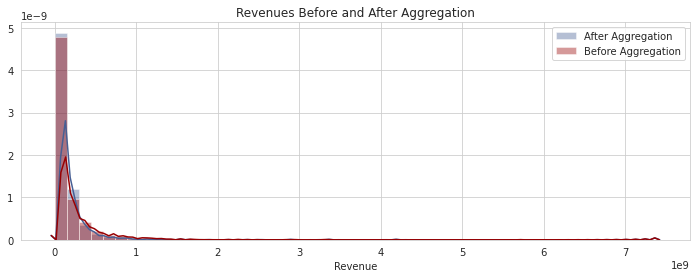

In [49]:
# plot target distributions

sns.distplot(y, color=mp.colors(0), label='After Aggregation')
sns.distplot(actor_df['revenue'], color=mp.colors(2), label='Before Aggregation')

plt.xlabel('Revenue')

plt.legend()
plt.title('Revenues Before and After Aggregation');

The aggregation has shifted the distribution of revenues toward lower values.

In [50]:
# observe statistical differences between distributions
print('Percent Differences of Dataset Percentiles After Aggregation:')
# specify percentiles to calculate
percentiles = [0.1, 0.5, 0.9]
# get percent differences
(y.describe(
    percentiles) - actor_df['revenue'].describe(
    percentiles)) / actor_df['revenue'].describe(
    percentiles) * 100

Percent Differences of Dataset Percentiles After Aggregation:


count   -71.695190
mean    -13.252189
std      -4.361509
min       0.000000
10%      56.911596
50%      19.091766
90%     -27.138356
max       0.000000
Name: revenue, dtype: float64

As expected, there are less observations for revenues after aggregation.<br>
The mean of the revenues is smaller after the aggregation.<br>
The median of the revenues is larger after the aggregation.<br>
The revenues are more heavily distributed to the lower percentiles after aggregation.

Note that because the revenues before aggregation are for individual movies, I will name the DataFrames using "movies".<br>
The resulting datasets will still be aggreagated over the actors, but only after the revenues have been modified.

 > **SCALED REVENUE BEFORE AGGREGATION**

Here, I will scale the movie revenues, then aggregate the data by actor.

In [51]:
# get DataFrame with scaled movies revenue, then aggregate over each actor
scaled_movies_df = aggregate_data(scale_revenue(actor_df))
scaled_movies_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,2.931757,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,0.933193,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,2.084246,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,3.318376,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,4.407034,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [52]:
# separate training data into features and target
scaled_movies_X = scaled_movies_df.drop('revenue', axis=1)
scaled_movies_y = scaled_movies_df['revenue']

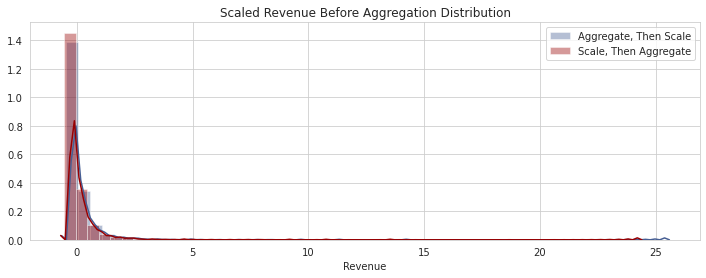

In [53]:
# plot target distributions

sns.distplot(scaled_y, color=mp.colors(0), label='Aggregate, Then Scale')
sns.distplot(scaled_movies_y, color=mp.colors(2), label='Scale, Then Aggregate')

plt.xlabel('Revenue')

plt.legend()
plt.title('Scaled Revenue Before Aggregation Distribution');

The distribution appears similar to the one where the data was aggregated before scaling.

In [54]:
# split dataset
scaled_movies_X_train, scaled_movies_X_test, \
scaled_movies_y_train, scaled_movies_y_test = train_test_split(
    scaled_movies_X, scaled_movies_y, test_size=0.2, random_state=27)

In [55]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Scaled Revenues', scaled_movies_X_train, scaled_movies_y_train, 
           scaled=True, scaled_df=actor_df)

Scaled Revenues 
Average MAE: $56,971,631.61       CV Range: ($53,496,937.72, $59,287,931.39)


The errors are not very different from those obtained through scaling after data aggregation.<br>
The average error is still slightly worse than that found by using the unmodified revenues.

 > **LOG REVENUE BEFORE AGGREGATION**

Now, I will apply the log transform, before data aggregation.

In [56]:
# get DataFrame with log movies revenue, then aggregate over each actor
log_movies_df = aggregate_data(get_log_revenue(actor_df))
log_movies_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,19.188312,8.725710e+07,46.683803,0,0.818182,44.132909,1997.818182,112.818182,1,7.145455,...,2,0,1,0,1,0,7,1,1,0
3,18.885104,8.557983e+07,55.134863,0,0.761905,25.411429,1997.190476,119.000000,1,6.730952,...,2,1,1,0,5,9,8,17,2,2
4,18.370769,7.547966e+07,40.177873,1,3.000000,32.998267,1996.466667,115.200000,1,6.660000,...,2,0,1,1,0,4,6,1,0,0
5,19.260451,2.398909e+07,59.706451,0,1.666667,37.167333,1972.666667,97.666667,0,7.400000,...,0,0,1,0,0,0,2,0,0,0
6,20.752725,1.007536e+08,44.757022,0,5.666667,60.116667,1990.333333,132.333333,0,7.483333,...,1,0,0,0,0,0,5,0,0,0


In [57]:
# separate training data into features and target
log_movies_X = log_movies_df.drop('revenue', axis=1)
log_movies_y = log_movies_df['revenue']

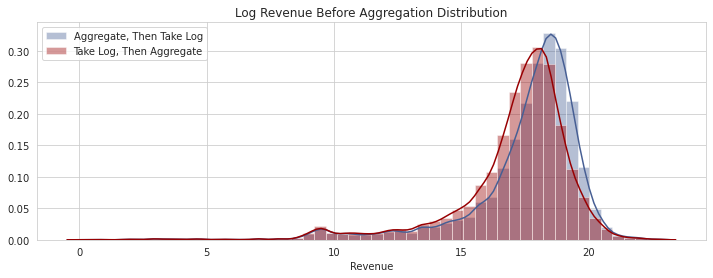

In [58]:
# plot target distributions

sns.distplot(log_y, color=mp.colors(0), label='Aggregate, Then Take Log')
sns.distplot(log_movies_y, color=mp.colors(2), label='Take Log, Then Aggregate')

plt.xlabel('Revenue')

plt.legend(loc=2)
plt.title('Log Revenue Before Aggregation Distribution');

The shift to lower values is easier to observe with the log data.

In [59]:
# split dataset
log_movies_X_train, log_movies_X_test, \
log_movies_y_train, log_movies_y_test = train_test_split(
    log_movies_X, log_movies_y, test_size=0.2, random_state=27)

In [60]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Log Revenues', log_movies_X_train, log_movies_y_train, log=True)

Log Revenues 
Average MAE: $53,194,579.23       CV Range: ($46,776,841.69, $61,359,167.12)


Unlike taking the log after aggregation, the average error has improved, slightly.

 > **NO OUTLIERS REVENUE BEFORE AGGREGATION**

Now I will observe the effect of removing the outliers, before aggregation.

In [61]:
# get DataFrame with no outliers revenue, then aggregate over each actor
no_movies_df = aggregate_data(remove_outliers(actor_df, before_agg=True))
no_movies_df.head()

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,2.425752e+07,8.778750e+06,45.773425,0,1.400000,13.497800,1997.000000,86.200000,1,6.620000,...,1,0,1,0,1,0,1,1,1,0
3,2.299171e+08,8.345003e+07,56.479322,0,0.783784,22.042243,1998.540541,118.027027,1,6.562162,...,1,1,1,0,5,9,4,17,2,2
4,5.191338e+07,2.402895e+07,38.717047,1,4.000000,8.555667,1995.111111,102.000000,1,6.044444,...,1,0,1,1,0,4,0,1,0,0
5,6.220332e+07,1.244080e+07,57.560388,0,1.000000,10.428500,1970.500000,86.000000,0,7.000000,...,0,0,1,0,0,0,1,0,0,0
6,1.166933e+08,1.531840e+07,32.731678,0,8.000000,11.983000,1978.000000,132.000000,0,6.500000,...,1,0,0,0,0,0,0,0,0,0


In [62]:
# separate training data into features and target
no_movies_X = no_movies_df.drop('revenue', axis=1)
no_movies_y = no_movies_df['revenue']

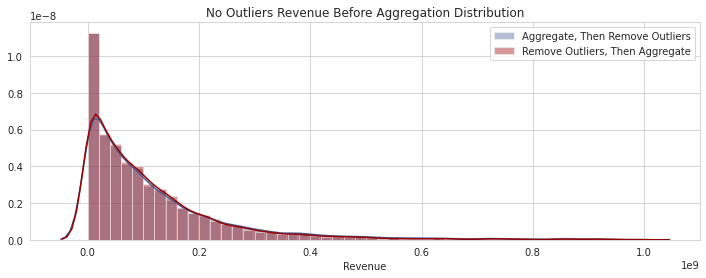

In [63]:
# plot target distributions

sns.distplot(no_y, color=mp.colors(0), label='Aggregate, Then Remove Outliers')
sns.distplot(no_movies_y, color=mp.colors(2), label='Remove Outliers, Then Aggregate')

plt.xlabel('Revenue')

plt.legend()
plt.title('No Outliers Revenue Before Aggregation Distribution');

The two distibutions closely overlap.

In [64]:
# split dataset
no_movies_X_train, no_movies_X_test, \
no_movies_y_train, no_movies_y_test = train_test_split(
    no_movies_X, no_movies_y, test_size=0.2, random_state=27)

In [65]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('No Outliers Revenues', no_movies_X_train, no_movies_y_train)

No Outliers Revenues 
Average MAE: $45,296,500.10       CV Range: ($41,594,757.40, $48,397,581.17)


Removing outliers before aggergation has improved the predictions, even more.

 > **NO OUTLIERS SCALED REVENUE BEFORE AGGREGATION**

Now, I will scale, remove outliers, and aggregate, in that order.

In [66]:
# get DataFrame with no outliers of scaled movies revenue, then aggregate over each actor
no_scaled_movies_df = aggregate_data(
    remove_outliers(scale_revenue(actor_df), before_agg=True))
no_scaled_movies_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,-0.455408,8.778750e+06,45.773425,0,1.400000,13.497800,1997.000000,86.200000,1,6.620000,...,1,0,1,0,1,0,1,1,1,0
3,0.235344,8.345003e+07,56.479322,0,0.783784,22.042243,1998.540541,118.027027,1,6.562162,...,1,1,1,0,5,9,4,17,2,2
4,-0.362520,2.402895e+07,38.717047,1,4.000000,8.555667,1995.111111,102.000000,1,6.044444,...,1,0,1,1,0,4,0,1,0,0
5,-0.327959,1.244080e+07,57.560388,0,1.000000,10.428500,1970.500000,86.000000,0,7.000000,...,0,0,1,0,0,0,1,0,0,0
6,-0.144942,1.531840e+07,32.731678,0,8.000000,11.983000,1978.000000,132.000000,0,6.500000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,-0.536759,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,-0.535669,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,-0.535669,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [67]:
# separate training data into features and target
no_scaled_movies_X = no_scaled_movies_df.drop('revenue', axis=1)
no_scaled_movies_y = no_scaled_movies_df['revenue']

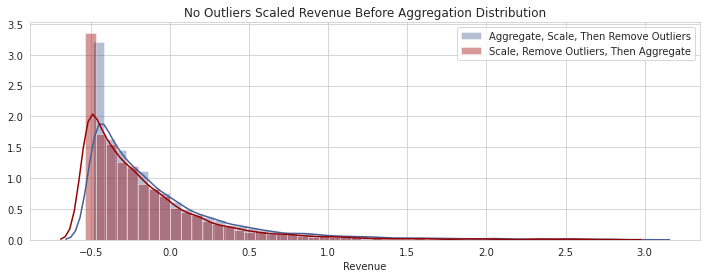

In [68]:
# plot target distributions

sns.distplot(no_scaled_y, color=mp.colors(0), 
             label='Aggregate, Scale, Then Remove Outliers')
sns.distplot(no_scaled_movies_y, color=mp.colors(2), 
             label='Scale, Remove Outliers, Then Aggregate')

plt.xlabel('Revenue')

plt.legend()
plt.title('No Outliers Scaled Revenue Before Aggregation Distribution');

The distribution has been shifted to lower values.

In [69]:
# split dataset
no_scaled_movies_X_train, no_scaled_movies_X_test, \
no_scaled_movies_y_train, no_scaled_movies_y_test = train_test_split(
    no_scaled_movies_X, no_scaled_movies_y, test_size=0.2, random_state=27)

In [70]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('No Outliers Scaled Revenues', 
           no_scaled_movies_X_train, no_scaled_movies_y_train, 
           scaled=True, scaled_df=actor_df)

No Outliers Scaled Revenues 
Average MAE: $45,334,447.47       CV Range: ($41,755,745.92, $48,369,214.76)


The average error has been improved, even more, when aggregating after modifications.

 > **LOG NO OUTLIERS REVENUE BEFORE AGGREGATION**

Finally, I will remove outliers, take the log, then aggregate the dataset.

In [71]:
# get DataFrame with log of no outliers movies revenue, then aggregate over each actor
log_no_movies_df = aggregate_data(
    get_log_revenue(remove_outliers(actor_df, before_agg=True)))
log_no_movies_df

,revenue,budget,age,gender,order,popularity,release_date,runtime,usa,vote_average,...,fantasy,history,horror,music,mystery,romance,science_fiction,thriller,war,western
person_id,,,,,,,,,,,,,,,,,,,,,
2,16.676154,8.778750e+06,45.773425,0,1.400000,13.497800,1997.000000,86.200000,1,6.620000,...,1,0,1,0,1,0,1,1,1,0
3,18.554333,8.345003e+07,56.479322,0,0.783784,22.042243,1998.540541,118.027027,1,6.562162,...,1,1,1,0,5,9,4,17,2,2
4,16.430098,2.402895e+07,38.717047,1,4.000000,8.555667,1995.111111,102.000000,1,6.044444,...,1,0,1,1,0,4,0,1,0,0
5,17.929196,1.244080e+07,57.560388,0,1.000000,10.428500,1970.500000,86.000000,0,7.000000,...,0,0,1,0,0,0,1,0,0,0
6,18.575060,1.531840e+07,32.731678,0,8.000000,11.983000,1978.000000,132.000000,0,6.500000,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2331666,10.515550,9.795870e+03,22.650705,1,5.000000,0.600000,2013.000000,87.000000,0,8.000000,...,0,0,0,0,0,0,0,0,0,0
2364949,12.797395,5.026406e+04,24.356421,1,0.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0
2364963,12.797395,5.026406e+04,24.047037,1,1.000000,12.463000,2019.000000,92.000000,0,7.500000,...,1,0,1,1,0,0,0,0,0,0


In [72]:
# separate training data into features and target
log_no_movies_X = log_no_movies_df.drop('revenue', axis=1)
log_no_movies_y = log_no_movies_df['revenue']

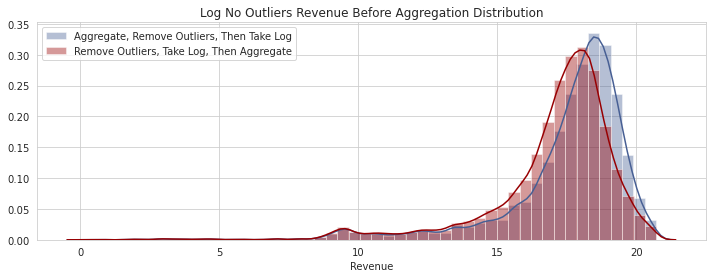

In [73]:
# plot target distributions

sns.distplot(log_no_y, color=mp.colors(0), 
             label='Aggregate, Remove Outliers, Then Take Log')
sns.distplot(log_no_movies_y, color=mp.colors(2), 
             label='Remove Outliers, Take Log, Then Aggregate')

plt.xlabel('Revenue')

plt.legend()
plt.title('Log No Outliers Revenue Before Aggregation Distribution');

The data is shifted to lower values, again.

In [74]:
# split dataset
log_no_movies_X_train, log_no_movies_X_test, \
log_no_movies_y_train, log_no_movies_y_test = train_test_split(
    log_no_movies_X, log_no_movies_y, test_size=0.2, random_state=27)

In [75]:
# get 10 fold CV MAE and MAE range over folds
get_cv_mae('Log No Outliers Revenues', log_no_movies_X_train, log_no_movies_y_train, 
           log=True)

Log No Outliers Revenues 
Average MAE: $41,215,414.04       CV Range: ($37,715,726.10, $44,835,561.81)


This technique has produced the best results.<br>
The average error has been reduced by 27%.

 > **MODIFIED REVENUES SUMMARY**

Here are the data manipulation results.

In [76]:
# organize and display results
for key, val in revenue_dict.items():
    print(key)
    if len(val) == 2:
        print('Aggregate First: ', val[0], '    Aggregate Last: ', val[1], '\n')
    else:
        print(val[0], '\n')

Original Revenues
$56,799,637.33 

Scaled Revenues
Aggregate First:  $56,914,594.28     Aggregate Last:  $56,971,631.61 

Log Revenues
Aggregate First:  $59,562,756.22     Aggregate Last:  $53,194,579.23 

No Outliers Revenues
Aggregate First:  $48,136,510.36     Aggregate Last:  $45,296,500.10 

No Outliers Scaled Revenues
Aggregate First:  $48,271,338.54     Aggregate Last:  $45,334,447.47 

Log No Outliers Revenues
Aggregate First:  $47,865,232.74     Aggregate Last:  $41,215,414.04 



Aggregating as the last step consistantly gives better results.<br>
The best technique is to remove outliers, take the log, then aggregate.<br>
I will use this method going forward.

In [77]:
# store modified dataset in JSON
log_no_movies_df.to_json('data/capstone2_optimized_target_ds.json')

 > **REMOVED OUTLIERS ANALYSIS**

I will observe the actors who were dropped due to outliers being removed.

In [78]:
# get count of actors dropped by outlier actor revenue
df.shape[0] - no_df.shape[0]

110

In [79]:
# get count of actors dropped by outlier movie revenue
df.shape[0] - no_movies_df.shape[0]

83

More actors were removed by dropping outlier actor average revenues than by dropping outlier movie revenues.

Here are the actors removed after aggregation.

In [80]:
# get ids of actors removed by outlier actor revenue
ids_removed_actor_outlier = np.setdiff1d(df.index.tolist(), no_df.index.tolist())
# get actor names from ids
names_removed_actor_outlier = actor_df[actor_df['person_id'].isin(
    ids_removed_actor_outlier)]['name'].unique()
names_removed_actor_outlier

array(['Mark Hamill', 'Peter Cushing', 'Anthony Daniels',
       'Ellen DeGeneres', 'Kenny Baker', 'Wolf Kahler',
       'Dominic Monaghan', 'Lee Arenberg', 'Thomas Mitchell',
       'Armelia McQueen', 'Bob Peck', 'Martin Ferrero', 'Roy Atwell',
       'Adriana Caselotti', 'Eddie Collins', 'Pinto Colvig',
       'Billy Gilbert', 'Ed Wynn', "Barbara O'Neil", 'Gloria Stuart',
       'Jeffrey Kramer', 'Chris Rebello', 'Jay Mello', 'Lee Fierro',
       'Olivia de Havilland', 'Shirley Eaton', 'Tania Mallet',
       'Claudine Auger', 'Luciana Paluzzi', 'Rik Van Nutter',
       'Molly Peters', 'Robert MacNaughton', 'K. C. Martel',
       'Haya Harareet', 'Vivien Leigh', 'Bonnie Wright', 'Clark Gable',
       'Leslie Howard', 'Evelyn Keyes', 'Ann Rutherford',
       'Hattie McDaniel', 'Cammie King', 'Jack MacGowran',
       'Frederick Worlock', 'David Frankham', 'Sebastian Cabot',
       'David Prowse', 'Peter Mayhew', 'Sebastian Shaw', 'Richard Haydn',
       'Don Barclay', 'Donnie Dunagan', 

Here are the actors removed, because all of their movies were outliers.

In [81]:
# get ids of actors removed by outlier movie revenue
ids_removed_movie_outlier = np.setdiff1d(df.index.tolist(), no_movies_df.index.tolist())
# get actor names from ids
names_removed_movie_outlier = actor_df[actor_df['person_id'].isin(
    ids_removed_movie_outlier)]['name'].unique()
names_removed_movie_outlier

array(['Ellen DeGeneres', 'Wolf Kahler', 'Bob Peck', 'Martin Ferrero',
       'Roy Atwell', 'Adriana Caselotti', 'Eddie Collins', 'Pinto Colvig',
       "Barbara O'Neil", 'Gloria Stuart', 'Chris Rebello', 'Lee Fierro',
       'Shirley Eaton', 'Tania Mallet', 'Claudine Auger',
       'Luciana Paluzzi', 'Rik Van Nutter', 'Molly Peters',
       'Robert MacNaughton', 'K. C. Martel', 'Haya Harareet',
       'Bonnie Wright', 'Leslie Howard', 'Evelyn Keyes', 'Ann Rutherford',
       'Hattie McDaniel', 'Cammie King', 'Frederick Worlock',
       'David Frankham', 'Sebastian Cabot', 'David Prowse',
       'Peter Mayhew', 'Sebastian Shaw', 'Don Barclay', 'Donnie Dunagan',
       'Cliff Edwards', 'Hardie Albright', 'Sam Edwards', 'Tim Davis',
       'Jimmy Smits', 'Ahmed Best', 'Mel Blanc', 'Will Wright',
       'Yvonne De Carlo', 'Louis Prima', 'Bruce Reitherman',
       'Sarah Vowell', 'Estelle Harris', 'Dickie Jones', 'Ilene Woods',
       'Claire Du Brey', 'Martha Wentworth', 'Ben Wright', 'Ji

Now, I will get the names of actors who had outlier average revenues, but were not removed by dropping outlier movies.

In [82]:
# get ids of actors with outlier actor revenue but not removed by outlier movie revenue
ids_remain_movie_outlier = np.setdiff1d(
    ids_removed_actor_outlier, ids_removed_movie_outlier)
# get actor names from ids
names_remain_movie_outlier = actor_df[actor_df['person_id'].isin(
    ids_remain_movie_outlier)]['name'].unique()
names_remain_movie_outlier

array(['Mark Hamill', 'Peter Cushing', 'Anthony Daniels', 'Kenny Baker',
       'Dominic Monaghan', 'Lee Arenberg', 'Thomas Mitchell',
       'Armelia McQueen', 'Billy Gilbert', 'Ed Wynn', 'Jeffrey Kramer',
       'Jay Mello', 'Olivia de Havilland', 'Vivien Leigh', 'Clark Gable',
       'Jack MacGowran', 'Richard Haydn', 'Pernilla August',
       'Sterling Holloway', 'Tony Jaa', 'Kitty Winn', 'Kathryn Beaumont',
       'Bill Thompson', 'Eleanor Audley', 'Verna Felton',
       'Heather Menzies', 'Daisy Ridley'], dtype=object)

They were in other movies, which kept them in the dataset, but didn't earn enough to keep their actor revenues as outliers.

I will observe the amounts their averages dropped in value, due to the removed movies.

In [83]:
# get adjusted revenues of actors with outlier actor revenue, after removing outlier movies
adj_revenues_remain_movie_outlier = np.array(no_movies_df[no_movies_df.index.isin(
    ids_remain_movie_outlier)]['revenue'])
# get revenues of actors with outlier actor revenue, before removing outlier movies
all_revenues_remain_movie_outlier = np.array(df[df.index.isin(
    ids_remain_movie_outlier)]['revenue'])
# get lost revenue credit, due to removed outlier actor revenues
lost_revenues_remain_movie_outlier = \
    all_revenues_remain_movie_outlier - adj_revenues_remain_movie_outlier
# create DataFrame with names and revenues of remaining outlier actors
pd.DataFrame(list(zip(
    names_remain_movie_outlier, 
    all_revenues_remain_movie_outlier, 
    adj_revenues_remain_movie_outlier, 
    lost_revenues_remain_movie_outlier)), 
             index=ids_remain_movie_outlier, 
             columns=['name', 'all_revenue', 'adj_revenue', 'lost_ave_revenue']
            ).sort_values(['lost_ave_revenue'], ascending=False)

,name,all_revenue,adj_revenue,lost_ave_revenue
5833,Ed Wynn,2.880976e+09,6.149720e+07,2.819479e+09
10538,Vivien Leigh,2.502390e+09,6.460050e+07,2.437789e+09
8725,Olivia de Havilland,2.519518e+09,9.029253e+07,2.429225e+09
67228,Kathryn Beaumont,3.275896e+09,8.513378e+08,2.424559e+09
34759,Sterling Holloway,2.546041e+09,3.610708e+08,2.184970e+09
29283,Richard Haydn,2.133749e+09,2.371392e+08,1.896610e+09
67290,Verna Felton,2.307162e+09,6.817863e+08,1.625376e+09
5464,Billy Gilbert,1.782108e+09,2.028046e+08,1.579303e+09
6,Anthony Daniels,1.471965e+09,1.166933e+08,1.355272e+09
67230,Bill Thompson,1.978841e+09,7.383035e+08,1.240538e+09


There is one actor, who is only in a single outlier movie, but does not have an outlier actor average revenue.

In [84]:
# get upper cut off revenue when eliminating outlier movies
upper_movie_revenue = np.mean(aggregate_data(
    actor_df, feature='movie_id')['revenue']) + np.std(aggregate_data(
    actor_df, feature='movie_id')['revenue']) * 3

print('Upper Movie Revenue: ', make_money(upper_movie_revenue))

Upper Movie Revenue:  $1,004,326,091.65


In [85]:
# upper cut off revenue when eliminating outlier actors
upper_actor_revenue = np.mean(aggregate_data(
    actor_df)['revenue']) + np.std(aggregate_data(
    actor_df)['revenue']) * 3

print('Upper Actor Revenue: ', make_money(upper_actor_revenue))

Upper Actor Revenue:  $992,878,928.34


In [86]:
# get actor not in any outlier movies, but with an outlier average movie revenue
actor_df[actor_df['name'] == 'Armelia McQueen'][['person_id', 'name', 'title', 'revenue']]

,person_id,name,title,revenue
8213,3420,Armelia McQueen,Ghost,9.996018e+08


Armelia McQueen was in only one movie, whose revenue was between the thresholds of actor and movie outlier revenues.

I will observe the names of the outlier movies.

In [87]:
# get removed outlier movies
outlier_movies = pd.concat(
    [actor_df, remove_outliers(actor_df)]).drop_duplicates(keep=False)['title'].unique()
outlier_movies

array(['Star Wars', 'Return of the Jedi', 'The Empire Strikes Back',
       'Star Wars: The Force Awakens', 'Star Wars: The Last Jedi',
       'Star Wars: The Rise of Skywalker', 'Raiders of the Lost Ark',
       'Star Wars: Episode III - Revenge of the Sith', 'Finding Nemo',
       'Finding Dory', 'Minions', 'The Hobbit: An Unexpected Journey',
       'Toy Story 4', 'Forrest Gump', 'Toy Story 3',
       'Harry Potter and the Prisoner of Azkaban',
       'The Dark Knight Rises', 'Harry Potter and the Goblet of Fire',
       'The Dark Knight', 'Alice in Wonderland',
       'Pirates of the Caribbean: On Stranger Tides',
       "Pirates of the Caribbean: At World's End",
       "Pirates of the Caribbean: Dead Man's Chest", 'Avengers: Endgame',
       'Avengers: Age of Ultron', 'The Avengers',
       'The Lord of the Rings: The Fellowship of the Ring',
       'The Lord of the Rings: The Return of the King',
       'The Lord of the Rings: The Two Towers',
       'Spider-Man: Far from Home',

This list mostly consists of movies that are part of a series.<br>
Many Disney movies made the list, as well as some Pixar films.<br>
Steven Spielberg and James Cameron have a handful of movies here, too.

Finally, I will observe all the actors, who were in outlier movies.<br>
Since the list is quite long, I will only get the number of those actors.

In [88]:
# get ids of actors in outlier movies
ids_in_movie_outlier = actor_df[actor_df['title'].isin(
    outlier_movies)]['person_id'].unique()
# get names of actors in outlier movies
actor_outlier_movies = actor_df[actor_df['person_id'].isin(
    ids_in_movie_outlier)]['name'].unique()
# get length of list of actors in outlier movies
print('There were {} actors in outlier movies.'.format(len(actor_outlier_movies)))

There were 558 actors in outlier movies.


Now, I will observe the actors with the largest decreases in their average actor revenue, due to dropping outlier movies.

In [89]:
# get ids for actors in movie outliers, but not dropped after movies removed
ids_in_movie_outlier_not_dropped = np.setdiff1d(
    ids_in_movie_outlier, ids_removed_movie_outlier)
# get ids for actors without outlier revenues who were not dropped after movies removed
ids_in_movie_outlier_not_outlier_actor_and_not_dropped = np.setdiff1d(
    ids_in_movie_outlier_not_dropped, ids_removed_actor_outlier)
# get adjusted revenues of actors in outlier movies, after movies have been removed
adj_revenues_outlier_movies = np.array(no_movies_df[no_movies_df.index.isin(
    ids_in_movie_outlier_not_outlier_actor_and_not_dropped)]['revenue'])
# get revenues of actors in outlier movies, before movies have been removed
all_revenues_outlier_movies = np.array(df[df.index.isin(
    ids_in_movie_outlier_not_outlier_actor_and_not_dropped)]['revenue'])
# get lost revenue credit, due to removed outlier movies
lost_ave_revenue = all_revenues_outlier_movies - adj_revenues_outlier_movies
# create DataFrame with names and revenues of actors in outlier movies
pd.DataFrame(list(zip(
    actor_outlier_movies, 
    all_revenues_outlier_movies, 
    adj_revenues_outlier_movies, 
    lost_ave_revenue)), index=ids_in_movie_outlier_not_outlier_actor_and_not_dropped, 
             columns=['name', 'all_revenue', 'adj_revenue', 'lost_ave_revenue']
            ).sort_values(['lost_ave_revenue'], ascending=False).head(30)

,name,all_revenue,adj_revenue,lost_ave_revenue
10989,Haley Joel Osment,9.862009e+08,2.066879e+06,9.841340e+08
20005,Ray Romano,8.688840e+08,9.738281e+06,8.591457e+08
17181,Jennifer Saunders,9.613917e+08,1.146293e+08,8.467623e+08
18998,BD Wong,8.424123e+08,1.781385e+07,8.245985e+08
13819,Anne Baxter,7.771106e+08,7.508800e+01,7.771105e+08
7331,Judd Hirsch,8.139084e+08,4.073156e+07,7.731768e+08
37366,Rosemary Harris,9.445651e+08,1.840800e+08,7.604851e+08
12094,Peter Coyote,8.901426e+08,1.515611e+08,7.385815e+08
1329,Robert Loggia,8.983389e+08,1.650787e+08,7.332602e+08
172069,Garry Shandling,7.949449e+08,6.253690e+07,7.324080e+08


There are a few big actors in this list, whose value greatly decreases, when outlier movies are removed.

In [90]:
def sort_outlier_movies(actor_name):
    """Print outlier movie occurances for given actor"""
    # get all movies for actor
    movies_lst = actor_df[actor_df['name'] == actor_name]['title']
    # sort out outlier movies
    outliers_lst = np.intersect1d(movies_lst, outlier_movies)
    # sort vocabulary to match number of outliers
    num_outliers = len(outliers_lst)
    phrase = 'was an outlier'
    if num_outliers > 1:
        phrase = 'were outliers'
    
    print('{} was in {} movies, but only {} of them {}:\n'.format(
    actor_name, len(movies_lst), num_outliers, phrase), outliers_lst)

In [91]:
# get Harrison Ford's outlier movie occurances
sort_outlier_movies('Harrison Ford')

Harrison Ford was in 42 movies, but only 5 of them were outliers:
 ['Raiders of the Lost Ark' 'Return of the Jedi' 'Star Wars'
 'Star Wars: The Force Awakens' 'The Empire Strikes Back']


In [92]:
# get Sandra Bullock's outlier movie occurances
sort_outlier_movies('Sandra Bullock')

Sandra Bullock was in 26 movies, but only 1 of them was an outlier:
 ['Minions']


In [93]:
# get Jeremy Irons' outlier movie occurances
sort_outlier_movies('Jeremy Irons')

Jeremy Irons was in 19 movies, but only 1 of them was an outlier:
 ['The Lion King']


In [94]:
# get Daniel Craig's outlier movie occurances
sort_outlier_movies('Daniel Craig')

Daniel Craig was in 22 movies, but only 1 of them was an outlier:
 ['Skyfall']


In [95]:
# get Will Smith's outlier movie occurances
sort_outlier_movies('Will Smith')

Will Smith was in 26 movies, but only 2 of them were outliers:
 ['Aladdin' 'Independence Day']


In [96]:
# get Jude Law's outlier movie occurances
sort_outlier_movies('Jude Law')

Jude Law was in 27 movies, but only 1 of them was an outlier:
 ['Captain Marvel']


Animation and series movies can greatly increase the average value of an actor, even for those who are well established.